In [1]:
import networkx as nx
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import norm
from scipy.stats import uniform
import matplotlib.pyplot as plt
import random


%matplotlib notebook
%matplotlib notebook

In [2]:
# some way to visualize the spread through the network
    # Maybe green for friendly, red for fight, black for dead
    # can tik through time steps using a scroller widget kind of thing



class evolve:
    
    def __init__(self, G, av_vipri, std_vipri, start, N, control):
        """
        G: a social network
        av_vipri: the average probability of being violent, will be drawn from a normal distribution
        std_vipri: the standard deviation of the normal distribution from which violence probabilities are drawn
        start: The first node, that will begin the spread ( a list or just one number)
        N: how many timesteps to iterate through
        control: Boolean, whether or not it is the control or experimental version 
        """
        self.G = G
        self.av_vipri = av_vipri
        self.std_vipri = std_vipri
        
        if type(start) == list:
            self.start = start
        else:
            self.start = [start]
            
        self.N = N
        self.control = control
    
        consdict = dict()
        
        for node in self.G.nodes:
            cons = []
            for ed in self.G.edges:
                if ed[0] == node:
                    cons.append(ed[1])
                elif ed[1] == node:
                    cons.append(ed[0])
            consdict[node] = cons
        nx.set_node_attributes(self.G, consdict, "connections")
        
        if not control:
            helps = []
            for i in range(int(len(self.G.nodes)/40)):
                num = random.randint(0,len(self.G.nodes)-1)
                if num not in helps:
                    helps.append(num)
                else:
                    #print('less')
                    pass
                    
        
        vidict = dict()
        for i in range(len(self.G.nodes)):
            if control:
                vidict[i] = abs(float(norm.rvs(size=1, loc = self.av_vipri, scale=self.std_vipri)))
            else:
                if i not in helps:
                    vidict[i] = abs(float(norm.rvs(size=1, loc = self.av_vipri, scale=self.std_vipri)))
                else:
                    vidict[i] = 'helper'
                    
        nx.set_node_attributes(self.G, vidict, "violence")
        
        helpdict = dict()
        for i in range(len(self.G.nodes)):
            if control:
                pass
            else:
                if i in helps:
                    helpdict[i] = float(norm.rvs(size=1, loc = 0.5, scale=0.2))
                    if helpdict[i] < 0:
                        helpdict[i] *= -1
                else:
                    helpdict[i] = 0
                    
        nx.set_node_attributes(self.G, helpdict, "helpfulness")

    
    def choose(self):
        """
        For each node in the list of nodes we are starting with/on at this point in the evolution
        Choose 1 other node in it's list of connections for it to interact with
        return choices: a dicitonary of the interactions that will occur in this step. "Key meets value"
        append new interactees to self.start
        """
        choices = dict() # a dicitonary of the interactions that will occur in this step. "Key meets value" 
        new = [] # a list of nodes who will be met and are being added to the start for next time step
        
        for node in self.start:
            cons = self.G.nodes[node]['connections']

            if len(cons) > 1:
                i = random.randint(0,len(cons)-1)
                choices[node] = cons[i]
                if cons[i] not in self.start:
                    new.append(cons[i])

            else:
                self.start.remove(node)
                
        for el in new:
            if el not in self.start:
                self.start.append(el)
  
        return choices
    
    
    def interact(self):
        """
        For every node in the dictionary of choice:
            use its probability of violence and its partners to determine the nature of the interaction
            if it is violent(one or two sided): there is a certain probability of death
                Update the probability of each individual based on the outcome to be more violent
            if it is friendly:
                update the probability of each individual to be less violent
        At the end, based on the counts of each interaction and the fatalities, 
            update the communities probability to violence
        """
        choices = self.choose()
        
        friendly = 0
        fights = 0
        medsuccess = 0
        medfail = 0
        
        for key in choices:
            
            v1 = self.G.nodes[key]['violence']
            p1 = uniform.rvs(size=1, loc=0, scale=1)

            v2 = self.G.nodes[choices[key]]['violence']
            p2 = uniform.rvs(size=1, loc=0, scale=1)
            
                
            if type(v1) == str and type(v2) == str:
                pass
            
            elif type(v1) == str: 
                phelp = uniform.rvs(size=1, loc=0, scale=1)
                if self.G.nodes[key]['helpfulness'] > phelp:
                    medsuccess += 1
                    self.G.nodes[choices[key]]['violence'] *= 0.5
                    self.G.nodes[key]['helpfulness'] *= 1.2
                    
                    for nod in self.G.nodes[choices[key]]['connections']:
                        try:
                            self.G.nodes[nod]['violence'] *= 0.5
                        except:
                            pass
                else:
                    medfail += 1
                    self.G.nodes[key]['helpfulness'] *= 1.1

            elif type(v2) == str:
                phelp = uniform.rvs(size=1, loc=0, scale=1)
                if self.G.nodes[choices[key]]['helpfulness'] > phelp:
                    medsuccess += 1
                    self.G.nodes[key]['violence'] *= 0.5
                    self.G.nodes[choices[key]]['helpfulness'] *= 1.2
                    
                    for nod in self.G.nodes[key]['connections']:
                        try:
                            self.G.nodes[nod]['violence'] *= 0.5
                        except:
                            pass
                else:
                    medfail += 1
                    self.G.nodes[choices[key]]['helpfulness'] *= 1.1

                
            elif p1 <= v1 and p2 <= v2: # two sided fight

                fights += 1
                
                self.G.nodes[key]['violence'] *= 1.1
                self.G.nodes[choices[key]]['violence'] *= 1.1

                for nod in self.G.nodes[key]['connections']:
                    try:
                        self.G.nodes[nod]['violence'] *= 1.05
                    except:
                        pass

                for nod in self.G.nodes[choices[key]]['connections']:
                    try:
                        self.G.nodes[nod]['violence'] *= 1.05
                    except:
                        pass


            elif p1 > v1 and p2 > v2: # friendly
                friendly += 1
                # lower both probabilities
                self.G.nodes[key]['violence'] *= 0.6

                self.G.nodes[choices[key]]['violence'] *= 0.6

                for nod in self.G.nodes[key]['connections']:
                    try:
                        self.G.nodes[nod]['violence'] *= 0.9
                    except:
                        pass

                for nod in self.G.nodes[choices[key]]['connections']:
                    try:
                        self.G.nodes[nod]['violence'] *= 0.9
                    except:
                        pass


            else: # one sided fight
                fights += 1
                
                self.G.nodes[key]['violence'] *= 1.1
                self.G.nodes[choices[key]]['violence'] *= 1.12

                for nod in self.G.nodes[key]['connections']:
                    try:
                        self.G.nodes[nod]['violence'] *= 1.05
                    except:
                        pass

                for nod in self.G.nodes[choices[key]]['connections']:
                    try:
                        self.G.nodes[nod]['violence'] *= 1.06
                    except:
                        pass
                    
        tot_vi = 0
        mems = 0
        for nod in self.G.nodes:
            if type(self.G.nodes[nod]['violence']) != str:
                mems += 1
                
                if self.G.nodes[nod]['violence'] < 0:
                    print(self.G.nodes[nod]['violence'])
                
                if self.G.nodes[nod]['violence'] > 1:
                    self.G.nodes[nod]['violence'] = 1

                if not control:
                    if self.G.nodes[nod]['violence'] >= 0.9:
                        pinterrupt = uniform.rvs(size=1, loc=0, scale=1)
                        if pinterrupt > comm_av_vi:
                            self.G.nodes[nod]['violence'] *= 0.5
                    
                tot_vi += self.G.nodes[nod]['violence']

        comm_av_vi = tot_vi / mems
                
        return friendly, fights, medsuccess, medfail, comm_av_vi
    
    
    def Go(self, plotinter=False, plotmeds = False):
        """
        Do the interactions for N time-steps
        return the number of:
            friendly interactions(frs),
            fights (fis)
            fatalities (fas)
        """
        frs = []
        fis =[]
        medss = []
        medfs = []
        comm_av_vis =[]
        for i in range(self.N):
            fr, fi, meds, medf, comm_av_vi = self.interact()
            frs.append(fr)
            fis.append(fi)
            medss.append(meds)
            medfs.append(medf)
            comm_av_vis.append(comm_av_vi)
            
        toti = []
        for fr, fi in zip(frs, fis):
            toti.append(fr+fi)

        for i, to in enumerate(toti):
            try:
                frs[i] /= to
            except:
                frs[i] = 0
            try:
                fis[i] /= to
            except:
                frs[i] = 0
            
        if plotinter:
            plt.style.use('seaborn-whitegrid')
            x = np.arange(len(frs))
                
            plt.plot(x, fis, label = 'fight', marker='x', c='red', alpha=0.8)
            plt.plot(x, frs, label = 'friend', marker='2', c='green', alpha=0.8)
            plt.plot(x, comm_av_vis, label = 'average violence', marker='1', c='orange', alpha=0.8)
            plt.title('Friendly and Violent Interactions (Experimental)')
            plt.xlabel('Time')
            plt.ylabel('Fraction of Total Interactions')
            plt.legend()
            plt.show()
        
        if plotmeds:
            plt.style.use('seaborn-whitegrid')
            x = np.arange(len(frs))
            
            totm = []
            for meds, medf in zip(medss, medfs):
                totm.append(meds+medf)
           
            for i, to in enumerate(toti):
                if to == 0:
                    medss[i] = 0
                    medfs[i] = 0
                else:
                    medss[i] /= to
                    medfs[i] /= to
                    
            plt.plot(x, medss, label = 'success', marker='x', c='blue', alpha=0.6)
            plt.plot(x, medfs, label = 'fail', marker='2', c='orange', alpha=0.6)
            plt.title('Successess and Failures in mediation')
            plt.xlabel('Time')
            plt.ylabel('Fraction of Total Interactions')
            plt.legend()
            plt.show()
        
        return frs, fis, medss, medfs, comm_av_vis


<IPython.core.display.Javascript object>


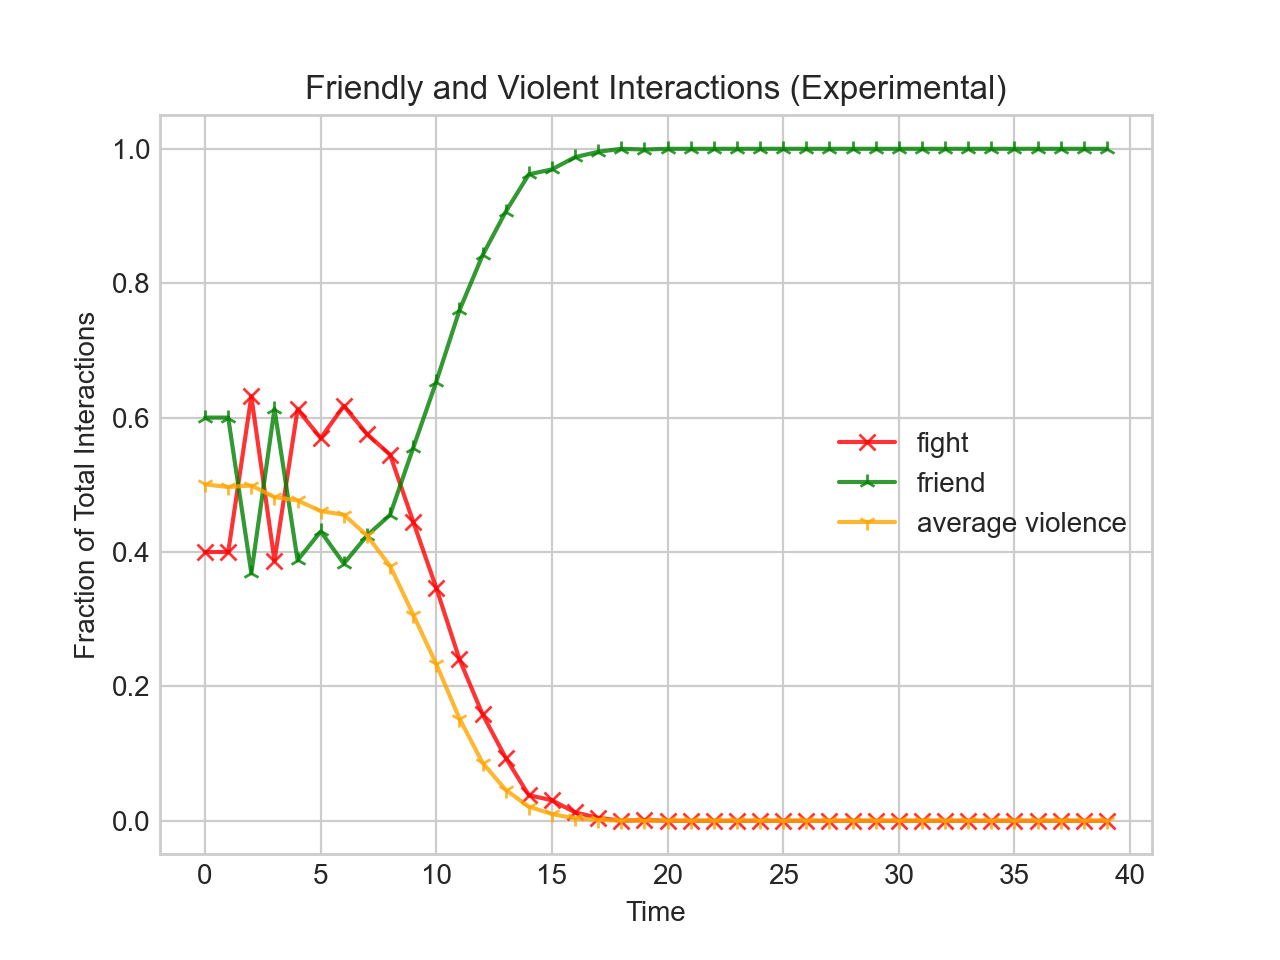

In [5]:
H = nx.barabasi_albert_graph(1000, 3)
control = evolve(H, 0.5, 0.2, [4, 10,99, 824, 333], 40, False)
x = control.Go(plotinter=True)

<IPython.core.display.Javascript object>


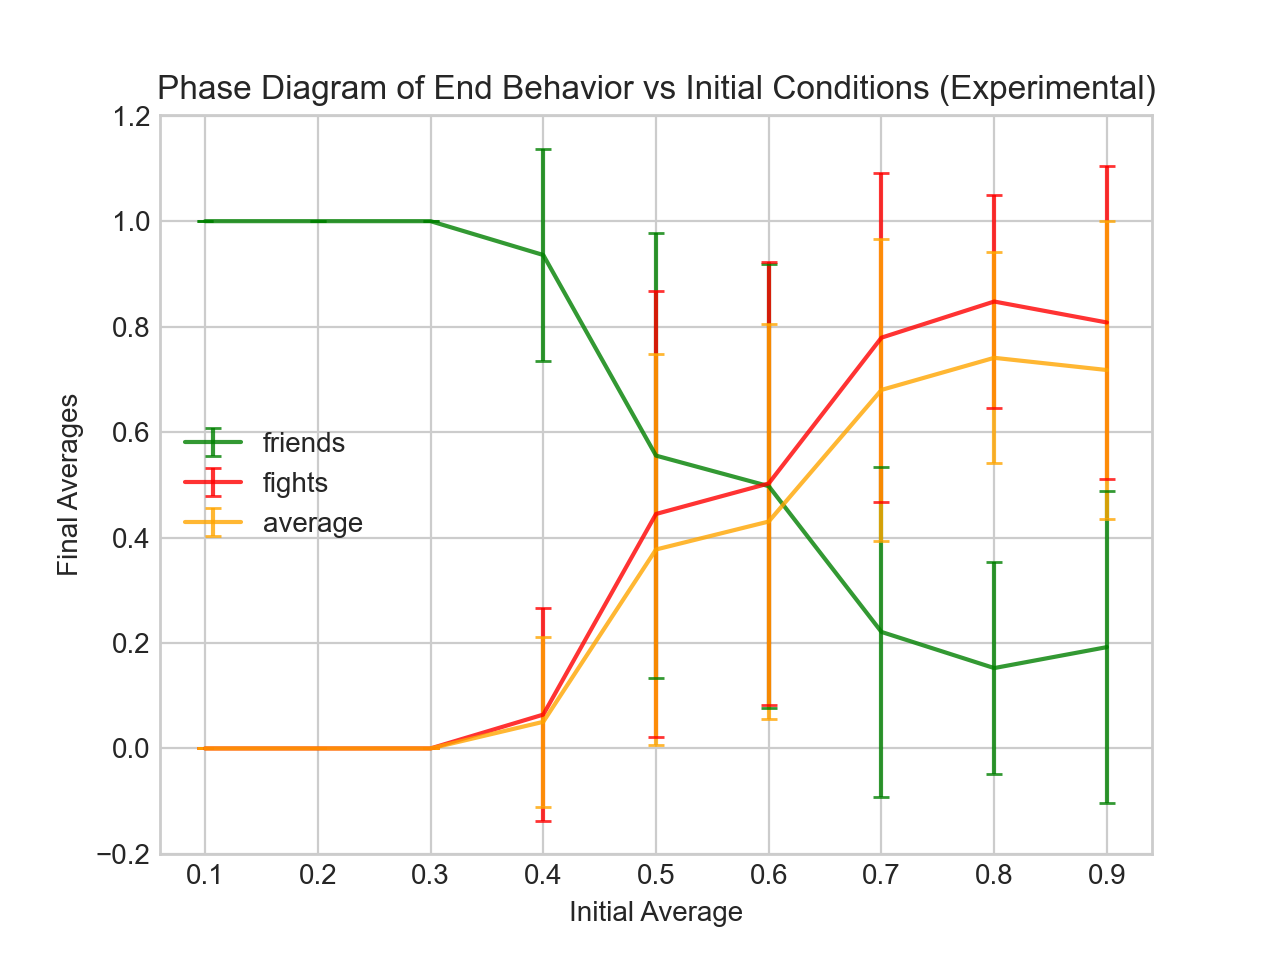

In [6]:
plt.close()

def end_behavior(start_avls, start_nodes, sample_size):
    """
    start_avls: a list of initial violence mean conditions to compare
    start_nodes: Nodes to initialize the spread
    sample_size: How many times to run the simulation with each initial condition
    """
    
    frsresults = dict()
    fisresults = dict()
    avsresults = dict()
    
    for av in start_avls:
        
        frsinterresults = []
        fisinterresults = []
        avsinterresults = []
        
        for i in range(sample_size):

            obj = evolve(H, av, 0.2, start_nodes, 40, False)
            frs, fis, medss, medfs, comm_av_vis = obj.Go()
            l20frs = []
            l20fis = []
            l20avs = []
            for i in range(1,20):
                l20frs.append(frs[-i])
                l20fis.append(fis[-i])
                l20avs.append(comm_av_vis[-i])

            frsinterresults.append(sum(l20frs) / len(l20frs))
            fisinterresults.append(sum(l20fis) / len(l20fis))
            avsinterresults.append(sum(l20avs) / len(l20avs))
            
        frsresults[av] = [sum(frsinterresults) / len(frsinterresults), np.std(frsinterresults)]
        fisresults[av] = [sum(fisinterresults) / len(fisinterresults), np.std(fisinterresults)]
        avsresults[av] = [sum(avsinterresults) / len(avsinterresults), np.std(avsinterresults)]
            
    
    return frsresults, fisresults, avsresults 
    
frsr, fisr, avsr = end_behavior([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], 3, 30)

frsrvals = []
frsrstds = []
fisrvals = []
fisrstds = []
avsrvals = []
avsrstds = []

for fr, fi, av in zip(frsr.values(), fisr.values(), avsr.values()):
    frsrvals.append(fr[0])
    frsrstds.append(fr[1])
    fisrvals.append(fi[0])
    fisrstds.append(fi[1])
    avsrvals.append(av[0])
    avsrstds.append(av[1])
    
plt.style.use('seaborn-whitegrid')
plt.title('Phase Diagram of End Behavior vs Initial Conditions (Experimental)')
plt.errorbar(list(frsr.keys()), frsrvals, yerr = frsrstds, label = 'friends', capsize=3, c='green', alpha=0.8)
plt.errorbar(list(fisr.keys()), fisrvals, yerr = fisrstds, label = 'fights',  capsize=3, c='red', alpha=0.8)
plt.errorbar(list(avsr.keys()), avsrvals, yerr = avsrstds, label = 'average', capsize=3, c='orange', alpha=0.8)
plt.xlabel("Initial Average")
plt.ylabel('Final Averages')
plt.legend()
plt.show()


#Explore the transition closer
#This is 30 itertations for each one